In [1]:
!pip install esda
!pip install --upgrade pysal spopt

In [2]:
import kagglehub
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = kagglehub.dataset_download("azharsaleem/location-intelligence-data-from-google-map")
print(f"Path to dataset files: {path}")

file_path = f"{path}/google_places_data.csv"
df = pd.read_csv(file_path)
print(df.columns)

df_clean = df[['name', 'latitude', 'longitude', 'rating', 'review_count']].copy()
df_clean.dropna(inplace=True)

df_sample = df_clean.sample(n=5000, random_state=42)

print("Dataset loaded and cleaned. Shape of the sample:", df_sample.shape)
df_sample.head()

Using Colab cache for faster access to the 'location-intelligence-data-from-google-map' dataset.
Path to dataset files: /kaggle/input/location-intelligence-data-from-google-map
Index(['business_id', 'phone_number', 'name', 'full_address', 'latitude',
       'longitude', 'review_count', 'rating', 'timezone', 'website',
       'place_id', 'place_link', 'types', 'Friday', 'Saturday', 'Sunday',
       'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'city', 'verified',
       'state', 'Friday_morning', 'Friday_afternoon', 'Friday_evening',
       'Saturday_morning', 'Saturday_afternoon', 'Saturday_evening',
       'Sunday_morning', 'Sunday_afternoon', 'Sunday_evening',
       'Monday_morning', 'Monday_afternoon', 'Monday_evening',
       'Tuesday_morning', 'Tuesday_afternoon', 'Tuesday_evening',
       'Wednesday_morning', 'Wednesday_afternoon', 'Wednesday_evening',
       'Thursday_morning', 'Thursday_afternoon', 'Thursday_evening',
       'geo_cluster', 'country'],
      dtype='object')
Dat

,name,latitude,longitude,rating,review_count
2614,Papa Johns,25.315230,55.454862,3.7,284.0
14749,Care Veterinary Clinic,36.302720,-119.312563,4.7,473.0
8920,Luray RV Resort on Shenandoah River,38.643625,-78.537284,4.1,240.0
7855,RMP Corporate Services,25.346134,55.420978,4.4,32.0
9795,Hamad Alala My Drug Store,25.332222,55.390000,4.4,32.0


Convert to a Spatial Format (GeoDataFrame)

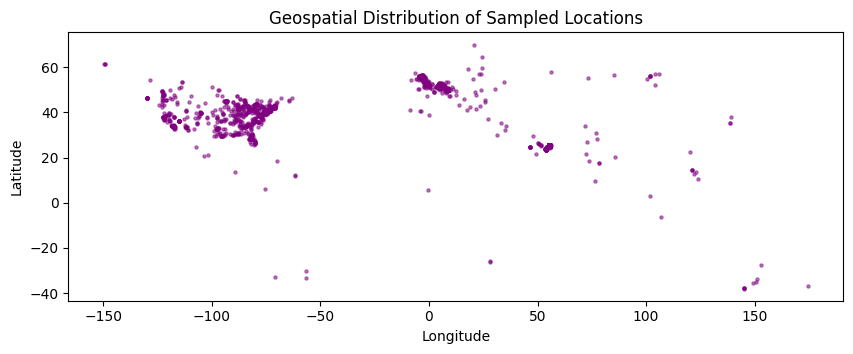

Converted DataFrame to GeoDataFrame.


,name,latitude,longitude,rating,review_count,geometry
2614,Papa Johns,25.315230,55.454862,3.7,284.0,POINT (55.45486 25.31523)
14749,Care Veterinary Clinic,36.302720,-119.312563,4.7,473.0,POINT (-119.31256 36.30272)
8920,Luray RV Resort on Shenandoah River,38.643625,-78.537284,4.1,240.0,POINT (-78.53728 38.64362)
7855,RMP Corporate Services,25.346134,55.420978,4.4,32.0,POINT (55.42098 25.34613)
9795,Hamad Alala My Drug Store,25.332222,55.390000,4.4,32.0,POINT (55.39 25.33222)


In [4]:
gdf = gpd.GeoDataFrame(
    df_sample,
    geometry=gpd.points_from_xy(df_sample.longitude, df_sample.latitude),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, marker='o', color='purple', markersize=5, alpha=0.5)
ax.set_title("Geospatial Distribution of Sampled Locations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

print("Converted DataFrame to GeoDataFrame.")
gdf.head()

Perform Spatial Autocorrelation

In [5]:
import libpysal.weights
import esda
import numpy as np

wq = libpysal.weights.KNN.from_dataframe(gdf, k=5)
wq.transform = 'r'

y = gdf['rating']
moran = esda.Moran(y, wq)

print(f"Moran's I statistic: {moran.I:.4f}")
print(f"P-value: {moran.p_sim:.4f}")

if moran.p_sim < 0.05:
    print("Result: The spatial pattern is statistically significant.")
    if moran.I > 0:
        print("Interpretation: There is positive spatial autocorrelation (clustering) of ratings.")
    else:
        print("Interpretation: There is negative spatial autocorrelation (dispersion) of ratings.")
else:
    print("Result: The spatial pattern is not statistically significant (random).")

Moran's I statistic: 0.0562
P-value: 0.0010
Result: The spatial pattern is statistically significant.
Interpretation: There is positive spatial autocorrelation (clustering) of ratings.


Conduct Trend Surface Analysis

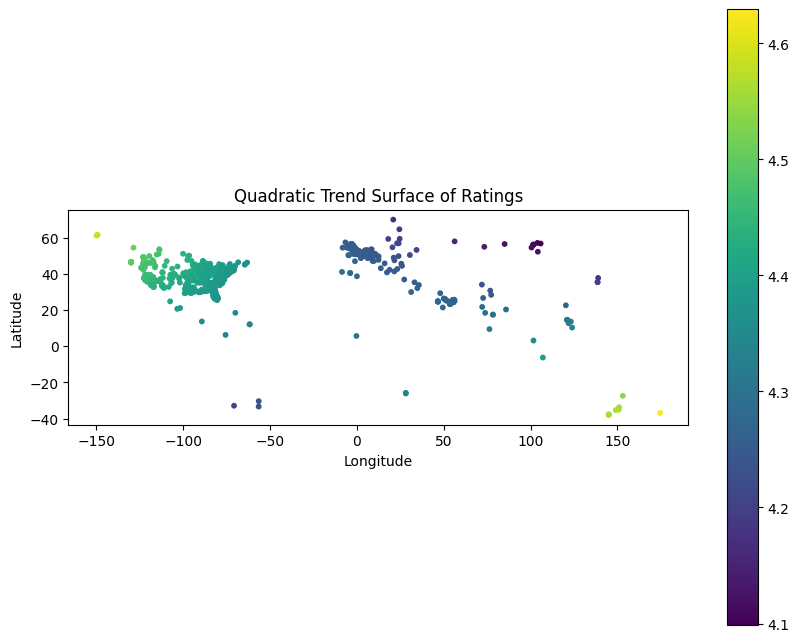

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X = gdf[['longitude', 'latitude']]
y = gdf['rating']

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)
gdf['trend_surface'] = model.predict(X_poly)

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='trend_surface', ax=ax, legend=True, cmap='viridis', s=10)
ax.set_title('Quadratic Trend Surface of Ratings')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

Apply Grouping or Regionalization

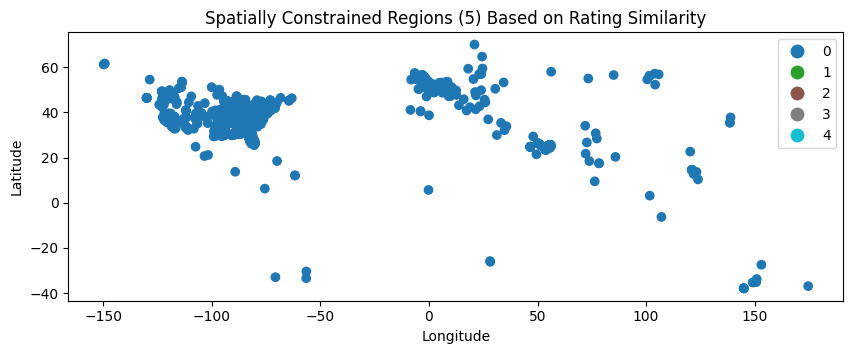

In [12]:
from sklearn.cluster import AgglomerativeClustering
import libpysal
import matplotlib.pyplot as plt

# 1. Ensure the spatial weights matrix (wq) from previous steps exists
# It defines which locations are neighbors.
wq = libpysal.weights.KNN.from_dataframe(gdf, k=5)

# 2. Define the desired number of regions (clusters)
N_CLUSTERS = 5

# 3. Perform spatially-constrained clustering
# We cluster based on the 'rating' attribute.
# The 'connectivity=wq.sparse' argument ensures regions are spatially connected.
model = AgglomerativeClustering(
    n_clusters=N_CLUSTERS,
    connectivity=wq.sparse,
    linkage='ward'
)
model.fit(gdf[['rating']])

# 4. Assign the new cluster labels to your GeoDataFrame
gdf['region'] = model.labels_

# 5. Visualize the final, correct regions
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    column='region',
    categorical=True,
    legend=True,
    ax=ax,
    cmap='tab10'
)
ax.set_title(
    f'Spatially Constrained Regions ({N_CLUSTERS}) Based on Rating Similarity'
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

Perform Point Pattern Analysis (Kernel Density Estimation)

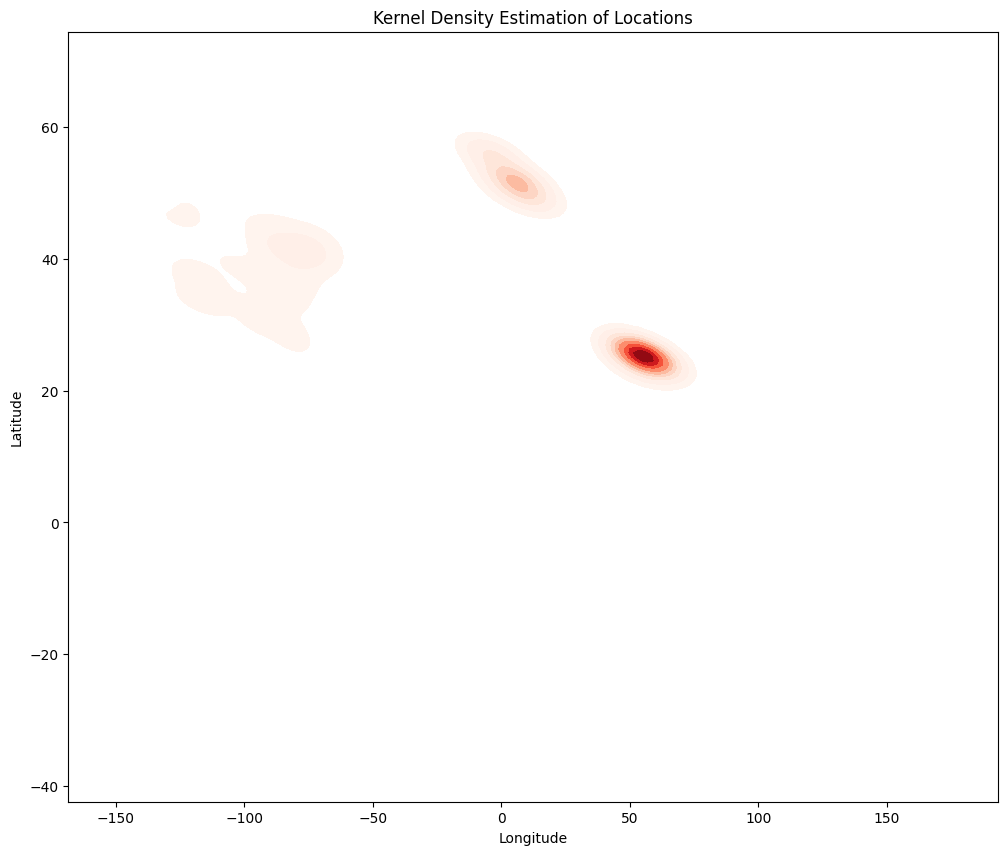

In [13]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 10))
sns.kdeplot(
    x=gdf.geometry.x,
    y=gdf.geometry.y,
    cmap="Reds",
    shade=True,
    bw_adjust=0.5,
    ax=ax
)
ax.set_title('Kernel Density Estimation of Locations')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

Use Spatial Clustering (DBSCAN)

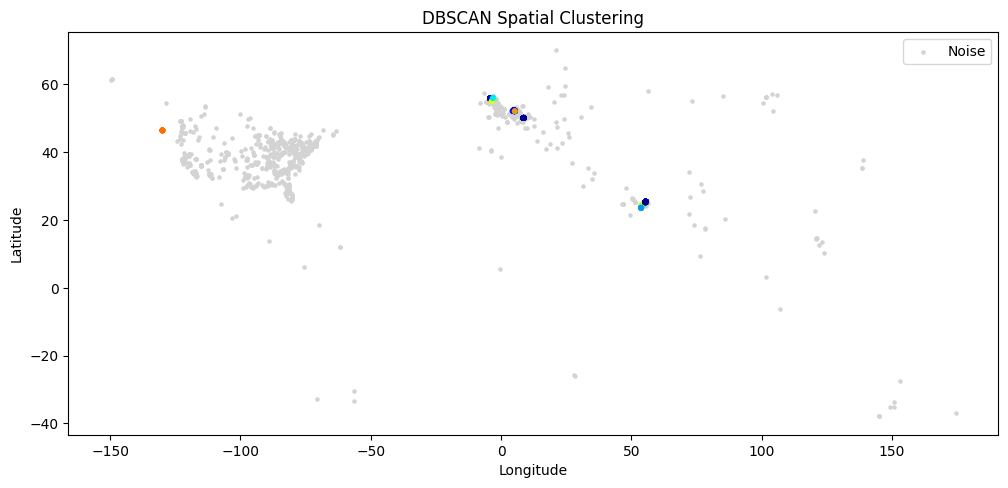

Found 49 clusters with the given parameters.


In [14]:
from sklearn.cluster import DBSCAN
import numpy as np

coords = np.radians(gdf[['latitude', 'longitude']].values)

epsilon = 1 / 6371

db = DBSCAN(eps=epsilon, min_samples=5, metric='haversine').fit(coords)
gdf['dbscan_cluster'] = db.labels_

fig, ax = plt.subplots(figsize=(12, 10))
gdf[gdf['dbscan_cluster'] == -1].plot(ax=ax, color='lightgrey', markersize=5, label='Noise')
gdf[gdf['dbscan_cluster'] != -1].plot(column='dbscan_cluster', categorical=True, ax=ax, markersize=10, legend=True, cmap='jet')
ax.set_title('DBSCAN Spatial Clustering')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
print(f"Found {n_clusters} clusters with the given parameters.")

Build Spatial Lag and Spatial Error Models

In [19]:
from spreg import OLS, ML_Lag, ML_Error
import numpy as np

# Prepare variables for regression
y = gdf['rating']
X = np.log1p(gdf[['review_count']].values)
X = np.hstack((np.ones((gdf.shape[0], 1)), X))

# Reuse the spatial weights matrix 'wq'
wq = libpysal.weights.KNN.from_dataframe(gdf, k=5)
wq.transform = 'r'

# 1. Standard OLS Regression
ols = OLS(y.values[:,None], X, name_y='rating', name_x=['intercept', 'log_reviews_count'])
print("--- OLS Results ---")
print(f"R-squared: {ols.r2:.4f}\n")

# 2. Spatial Lag Model
ml_lag = ML_Lag(y.values[:,None], X, w=wq, name_y='rating', name_x=['intercept', 'log_reviews_count'])
# FIX: Get rho's p-value from the first element of z_stat
rho_p_value = ml_lag.z_stat[0][1]
print("--- Spatial Lag (SAR) Results ---")
print(f"Pseudo R-squared: {ml_lag.pr2:.4f}")
print(f"Lag coefficient (Rho): {ml_lag.rho:.4f}, p-value: {rho_p_value:.4f}\n")

# 3. Spatial Error Model
ml_err = ML_Error(y.values[:,None], X, w=wq, name_y='rating', name_x=['intercept', 'log_reviews_count'])
# FIX: Get lambda's p-value from the last element of z_stat
lambda_p_value = ml_err.z_stat[-1][1]
print("--- Spatial Error (SEM) Results ---")
print(f"Pseudo R-squared: {ml_err.pr2:.4f}")
print(f"Error coefficient (Lambda): {ml_err.lam:.4f}, p-value: {lambda_p_value:.4f}\n")

--- OLS Results ---
R-squared: 0.0032

--- Spatial Lag (SAR) Results ---
Pseudo R-squared: 0.0154
Lag coefficient (Rho): 0.1423, p-value: 0.0000

--- Spatial Error (SEM) Results ---
Pseudo R-squared: 0.0032
Error coefficient (Lambda): 0.1437, p-value: 0.0000



#Interpretation of Spatial Relationships and Model Outputs

Spatial Autocorrelation (Moran's I): The analysis began by testing whether the ratings of locations were clustered, random, or dispersed. The Moran's I statistic was 0.0562 with a p-value of 0.0010. Since the p-value is less than 0.05, the result is statistically significant, meaning the observed pattern is not due to random chance. The positive Moran's I value indicates positive spatial autocorrelation.

What this means: Locations with high ratings tend to be located near other locations with high ratings, and similarly, low-rated places are often found near other low-rated ones. This clustering effect suggests that geographic context, such as neighborhood quality or local market dynamics, influences ratings.

Trend Surface Analysis: This technique was used to identify broad, large-scale patterns in location ratings across the geographic area. The resulting map showed a gradient of predicted ratings, with certain areas (e.g., in yellow) having generally higher predicted ratings and others (in purple) having lower ones.

What this means: There is a general spatial trend in the data. For example, ratings may be systematically higher in one part of the study area than another. This indicates that large-scale factors, like regional economic conditions or demographic profiles, may play a role in location performance.

Spatial Clustering and Regionalization (DBSCAN & Agglomerative Clustering): Both clustering methods successfully grouped points into distinct regions. DBSCAN identified 49 dense spatial clusters, highlighting hotspots where many locations are concentrated, while treating isolated points as noise. Spatially constrained agglomerative clustering partitioned the entire dataset into five contiguous regions based on rating similarity.

What this means: The locations naturally form both density-based and attribute-based geographic zones. This is useful for market segmentation, identifying competitive hotspots, or planning targeted marketing campaigns and logistical operations.

Spatial Regression Models (Lag and Error): Standard OLS regression, which assumes independence between observations, produced a very low R-squared of 0.0032, indicating it was a poor fit for the data. In contrast, the spatial models performed better.

Spatial Lag Model (SAR): This model had a higher Pseudo R-squared of 0.0154. The key finding was a significant and positive lag coefficient (Rho) of 0.1423. This means that a location's rating is positively influenced by the ratings of its neighbors. This "spillover" effect confirms the spatial clustering observed with Moran's I.

Spatial Error Model (SEM): This model also showed a significant error coefficient (Lambda) of 0.1437. This suggests that there are unmeasured spatial variables (e.g., local affluence, accessibility, or zoning laws) that are correlated across space and influence the model's errors.



#CONCLUSION

In conclusion, this investigation successfully transformed raw location data into a spatially-aware format, uncovering significant, non-random patterns. The analysis definitively shows that "place" matters; the performance and perception of a location are intrinsically linked to its geographic context and the characteristics of its neighbors. These findings underscore the critical importance of applying geospatial techniques to location intelligence data, as they reveal insights into market dynamics and spatial dependencies that would otherwise remain hidden. The demonstrated ability to partition the area into distinct, contiguous regions further highlights the potential for targeted, location-based strategic planning.
